In [177]:
from sklearn import metrics, datasets
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt

In [178]:
digits = datasets.load_digits()
num_examples = len(digits.data)
num_split = int(0.7*num_examples)

In [179]:
train_features = digits.data[:num_split]/16
train_labels =  digits.target[:num_split]
test_features = digits.data[num_split:]/16
test_labels = digits.target[num_split:]
classes = [0,1,2,3,4,5,6,7,8,9]

In [180]:
class myEM():
    
    def __init__(self, seed = 22, eps = 0.01):
        self.seed = seed
        self.eps = eps
        self.mu = None
        self.sigma2 = None
        self.prior = None
    
    def EM_GMM(self, data, classes):
        self.classes = classes
        K = len(classes)
        np.random.seed(self.seed)
        
        prior = np.ones(K)/K
        
        numbers = np.random.choice(540, size=[K,int(len(data)/K)], replace=False)
        
        mu = np.empty([K, len(data[0])])
        sigma2 = np.empty([K, len(data[0])])
        for k in range(K):
            mu[k] = np.mean(data[numbers[k]], axis=0)
            sigma2[k] = np.var(data[numbers[k]], axis=0)
        
        sigma2 += self.eps
        
        P = np.empty([len(data), K])
        r = np.empty([len(data), K])
        prev_prior = np.zeros(K)
        
        while np.linalg.norm(prev_prior - prior) > 0.001:
                             
            # E
            for k in range(K):
                for i,image in enumerate(data):
                    P[i, k] = np.prod(self.prob(image, mu[k], sigma2[k]))
                
            r = prior * P / (np.sum(prior * P, axis = 1)).reshape(-1,1)
            
            # M
            r_k = np.sum(r, axis = 0)
            prev_prior = prior #For stop condition
            prior = r_k / np.sum(r_k)
                             
            for k in range(K):
                mu[k] = np.sum(r[:, k].reshape(-1,1) * data, axis = 0) / r_k[k]
                sigma2[k] = np.diag((r[:, k].reshape(-1,1) * (data[0] - mu[k])).T @ (data - mu[k]) / r_k[k])
                   
            sigma2 += self.eps
            
        
        self.mu = mu
        self.sigma2 = sigma2
        self.prior = prior
    
    def prob(self, x, mu, sigma2):        
        return 1/np.sqrt(2*np.pi*sigma2) * np.exp(- 1/(2*sigma2) * (x - mu)**2)
        
    def predict(self, data):
        preds = np.empty(len(data))
        prob = np.zeros(len(self.classes))
        
        for i, image in enumerate(data):
            for k in range(len(self.classes)):                
                prob[k] = self.prior[k] * np.prod(self.prob(image, self.mu[k], self.sigma2[k]))
                  
            preds[i] = np.argmax(prob)
        
        return preds

In [181]:
em = myEM()
em.EM_GMM(test_features, classes)


In [182]:
p = em.predict(test_features)

In [183]:
print("Classification report SKLearn GNB:\n%s\n"
      % (metrics.classification_report(test_labels, p)))
print("Confusion matrix SKLearn GNB:\n%s" % metrics.confusion_matrix(test_labels, p))

Classification report SKLearn GNB:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.45      0.66      0.53        53
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        57
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        54
           7       0.00      0.00      0.00        54
           8       0.03      0.04      0.04        52
           9       0.00      0.00      0.00        55

    accuracy                           0.07       540
   macro avg       0.05      0.07      0.06       540
weighted avg       0.05      0.07      0.06       540


Confusion matrix SKLearn GNB:
[[ 0  0  1 51  0  0  0  0  1  0]
 [ 0 35  0  0  0 17  0  0  1  0]
 [ 0  0  0  1 38  0 14  0  0  0]
 [ 6  6  0  0  0  0 39  0  1  1]
 [ 2  2 53  0  0  0  0  0  0  0]
 [ 0  0  0

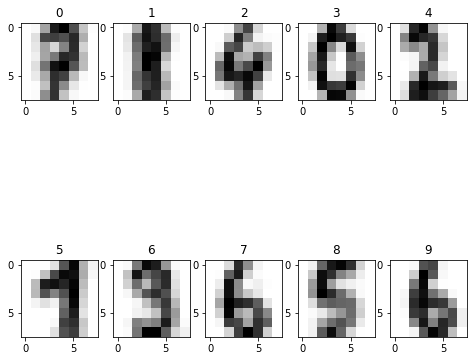

In [184]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(em.mu[i]*16,(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(i)
plt.show()

In [185]:
preds_fix = np.zeros(len(p))
preds_fix[p == 0] = 7
preds_fix[p == 1] = 8
preds_fix[p == 2] = 4
preds_fix[p == 3] = 0
preds_fix[p == 4] = 2
preds_fix[p == 5] = 1
preds_fix[p == 6] = 9
preds_fix[p == 7] = 6
preds_fix[p == 8] = 5
preds_fix[p == 9] = 3

In [186]:
ptr = em.predict(train_features)
print('completeness score: %s'  % metrics.completeness_score( train_labels, ptr))
print('homogeneity score: %s' % metrics.homogeneity_score( train_labels, ptr))
print('mutual info: %s' %metrics.adjusted_mutual_info_score( train_labels, ptr))

completeness score: 0.7444619620625899
homogeneity score: 0.7110693899800812
mutual info: 0.7233315107773973


In [187]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, preds_fix))

Confusion matrix:
[[51  0  0  0  1  1  0  0  0  0]
 [ 0 17  0  0  0  1  0  0 35  0]
 [ 1  0 38  0  0  0  0  0  0 14]
 [ 0  0  0  1  0  1  0  6  6 39]
 [ 0  0  0  0 53  0  0  2  2  0]
 [ 0  0  0  0  0 53  1  0  0  2]
 [ 0  0  0 29  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0 52  2  0]
 [ 0  1  0  0  0  2  2  6 33  8]
 [ 0  5  0  0  0  3  0  2  0 45]]


In [76]:
from sklearn.cluster import KMeans

In [15]:
kmeans = KMeans(n_clusters=10, random_state = 22)
kmeans.fit(train_features)

KMeans(n_clusters=10, random_state=22)

In [16]:

p2 = kmeans.predict(test_features)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, p2))

Confusion matrix:
[[ 0  1  0  0  0 52  0  0  0  0]
 [ 0  0  0  0  1  0  0 35  0 17]
 [ 3  0  0  0  0  1 42  0  7  0]
 [ 1  0  0  3  2  0  0  6 41  0]
 [ 0 52  0  3  0  1  0  0  0  1]
 [18  1  1  0 36  0  0  0  0  0]
 [ 0  0 52  0  0  0  0  1  0  1]
 [ 0  0  0 52  0  0  0  2  0  0]
 [12  0  0  2  1  0  1 34  1  1]
 [42  0  0  1  4  0  0  0  3  5]]


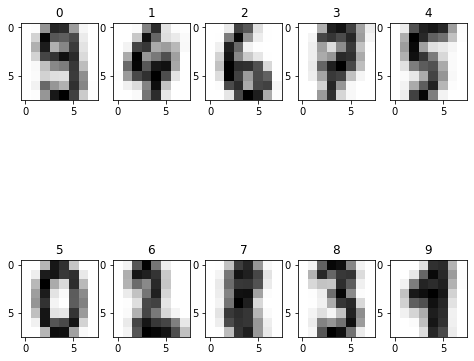

In [17]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 2
for i in range(10):
    img = np.reshape(kmeans.cluster_centers_[i],(8,8))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(i)
plt.show()

In [18]:
preds_fix2 = np.zeros(len(p2))
preds_fix2[p2 == 0] = 9
preds_fix2[p2 == 1] = 4
preds_fix2[p2 == 2] = 6
preds_fix2[p2 == 3] = 7
preds_fix2[p2 == 4] = 5
preds_fix2[p2 == 5] = 0
preds_fix2[p2 == 6] = 2
preds_fix2[p2 == 7] = 8
preds_fix2[p2 == 8] = 3
preds_fix2[p2 == 9] = 1

In [19]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, preds_fix2))

Confusion matrix:
[[52  0  0  0  1  0  0  0  0  0]
 [ 0 17  0  0  0  1  0  0 35  0]
 [ 1  0 42  7  0  0  0  0  0  3]
 [ 0  0  0 41  0  2  0  3  6  1]
 [ 1  1  0  0 52  0  0  3  0  0]
 [ 0  0  0  0  1 36  1  0  0 18]
 [ 0  1  0  0  0  0 52  0  1  0]
 [ 0  0  0  0  0  0  0 52  2  0]
 [ 0  1  1  1  0  1  0  2 34 12]
 [ 0  5  0  3  0  4  0  1  0 42]]


In [20]:
print(metrics.accuracy_score(test_labels, preds_fix2))

metrics.accuracy_score(test_labels, preds_fix)

ptr = kmeans.predict(train_features)
print('completeness score: %s'  % metrics.completeness_score( train_labels, ptr))
print('homogeneity score: %s' % metrics.homogeneity_score( train_labels, ptr))
print('mutual info: %s' %metrics.adjusted_mutual_info_score( train_labels, ptr))

0.7777777777777778
completeness score: 0.7504785316995707
homogeneity score: 0.7426772208333396
mutual info: 0.7428730082204416


In [24]:
print(metrics.accuracy_score(preds_fix, preds_fix2))

metrics.accuracy_score(preds_fix, preds_fix)

ptr1 = em.predict(train_features)
print('completeness score: %s'  % metrics.completeness_score( ptr, ptr1))
print('homogeneity score: %s' % metrics.homogeneity_score( ptr, ptr1))
print('mutual info: %s' %metrics.adjusted_mutual_info_score( ptr, ptr1))

0.7851851851851852
completeness score: 0.7811134907166012
homogeneity score: 0.748562102992862
mutual info: 0.760936434534244
